In [1]:
from datetime import datetime, timedelta
import yfinance as yf
import mplfinance as mpf

import pandas as pd 
import numpy as np
import utils
import pickle
import xgboost as xgb

In [2]:
ticker = "AAPL"

alternative_data = utils.get_alternative_data()
technical_data = utils.get_full_technical_data(ticker)

full_df = alternative_data.join(technical_data)
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
full_df.dropna(inplace=True)

c:\Users\nopro\OneDrive\Desktop\Monk3yStocks\utils.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  aaii_days = ((aaii.tail(1).index  - pd.datetime.today()).days[0]*-1) - 1
c:\Users\nopro\OneDrive\Desktop\Monk3yStocks\utils.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aaii = aaii.append([aaii.tail(1)]*aaii_days)
c:\Users\nopro\OneDrive\Desktop\Monk3yStocks\utils.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  aaii_index = pd.date_range('1987/07/31', pd.datetime.today())
c:\Users\nopro\OneDrive\Desktop\Monk3yStocks\utils.py:25: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  bigmac_days 

[*********************100%***********************]  1 of 1 completed


In [3]:
# Get predictions

# Load the model from a file
with open('bull_xgb_model.pkl', 'rb') as f:
    bull_model = pickle.load(f)

# Load the model from a file
with open('bear_xgb_model.pkl', 'rb') as f:
    bear_model = pickle.load(f)

features = ['Returns', 'Unemployment Rate', 'Inflation Rate', 'Misery Index',
       'local_price', 'Bullish', 'Neutral', 'Bearish', 'EMA12_pctchg', 'RSI',
       'Pct_Chg', 'MACD_sentiment', 'Upper_BB_pctchg', 'Lower_BB_pctchg',
       'EMA_sentiment', 'Volume_sentiment']

full_df = utils.get_model_predictions(full_df, bull_model, bear_model, features)

### Visualize

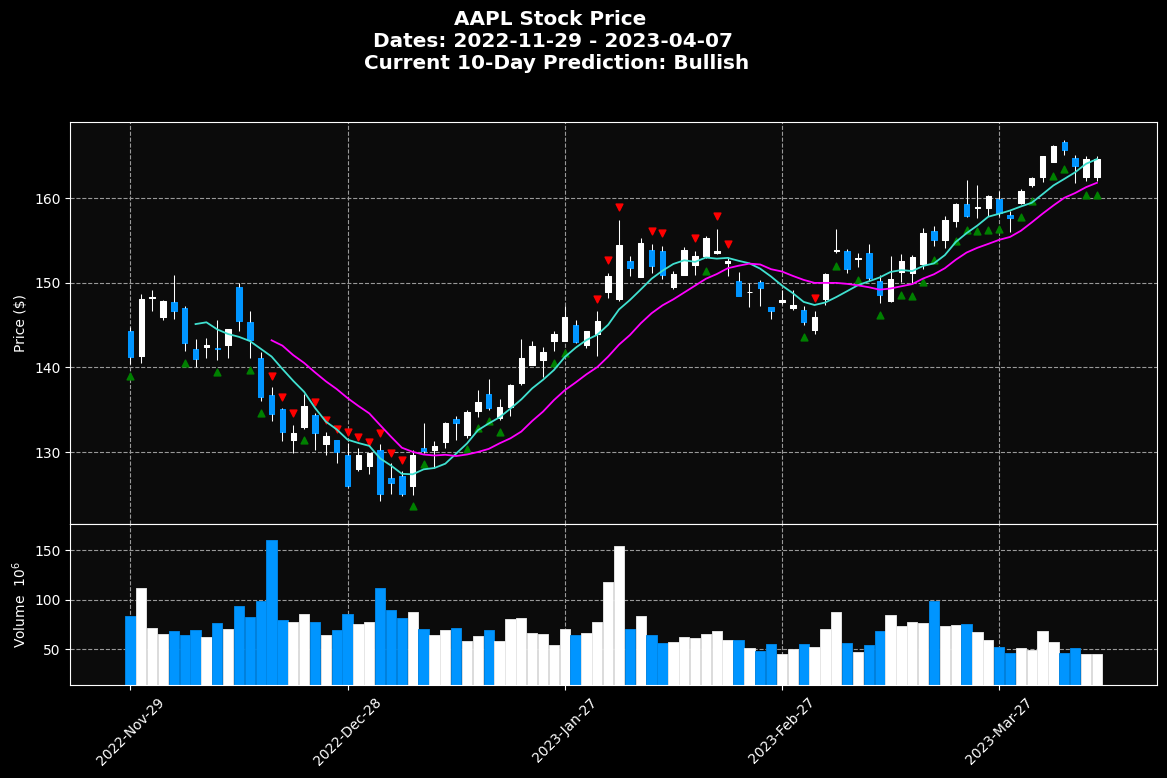

In [4]:
n_obs = 90
plot_data = full_df.tail(n_obs)
start_date = plot_data.index[0].strftime('%Y-%m-%d')
todays_date = plot_data.index[-1].strftime('%Y-%m-%d')

# get today's prediction
today = full_df.tail(1)
if today['buy_signal'][0] == today['sell_signal'][0]:
    ten_day_prediction = 'Neutral'
elif today['buy_signal'][0] == True:
    ten_day_prediction = 'Bullish'
elif today['sell_signal'][0] == True:
    ten_day_prediction = 'Bearish'

mc = mpf.make_marketcolors(up='g',down='r',
                           edge='black',
                           wick={'up':'black','down':'black'},
                           volume='in',
                           ohlc='black')
s  = mpf.make_mpf_style(marketcolors=mc, gridstyle='--')

mpf.plot(plot_data, type='candle', volume=True, 
        title=f"{ticker} Stock Price \n Dates: {start_date} - {todays_date} \n Current 10-Day Prediction: {ten_day_prediction}",
         ylabel='Price ($)', mav=(7, 14), figratio=(15, 8), figscale=1.4,
        style='nightclouds', show_nontrading=False, 
         addplot=[
             mpf.make_addplot(plot_data['buy_marker'], type='scatter', markersize=24, marker='^', color='green', panel=0, ylabel='Buy Signals'),
             mpf.make_addplot(plot_data['sell_marker'], type='scatter', markersize=24, marker='v', color='red', panel=0, ylabel='Sell Signals'),
         ])